### Experiment

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp
import neptune
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.preprocessing import StandardScaler
import quantstats as qs
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import brier_score_loss, f1_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from data_generation import * 
from visualization import * 

In [3]:
hparams_ = {'steps': [200, 2000, 10000], 'SNR':[[-0.05, -0.05, 0.1], [0.4, -0.45, -0.4], [0.6, -0.45, 0.65]], 
            'max_samples':[round(x,2) for x in np.linspace(0.6, 0.8, 2)], 'ccp_alpha':[round(x,4) for x in np.linspace(0., 0.001, 2)]}
hparams = (dict(zip(hparams_, i)) for i in product(*hparams_.values()))

0it [00:00, ?it/s]

https://app.neptune.ai/tommylee1013/Random-Forest/


0it [00:04, ?it/s]


AttributeError: 'PolyCollection' object has no property 'bin'

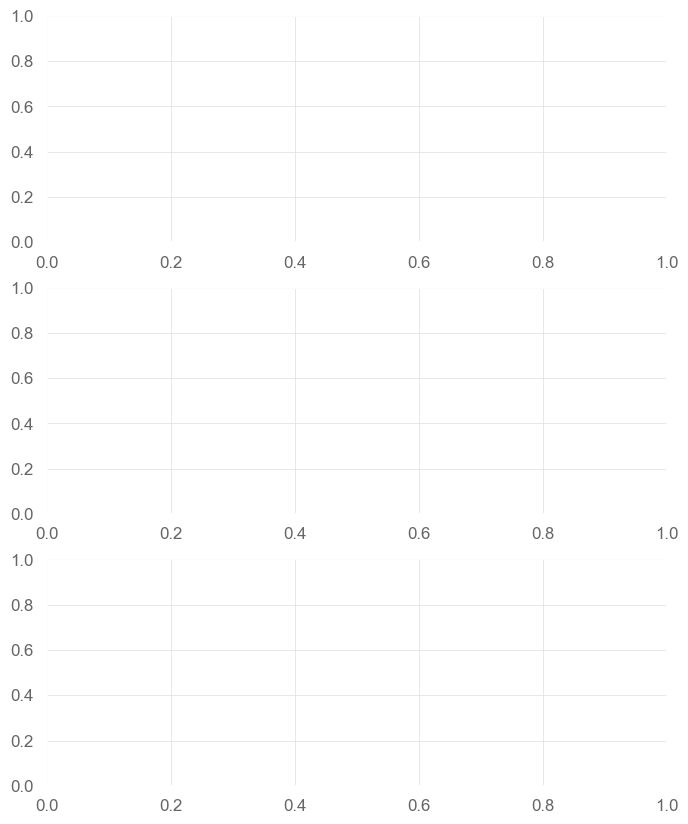

In [36]:
for params in tqdm(hparams):

    # neptune initialization
    run = neptune.init_project(project="tommylee1013/Random-Forest", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNjIxNjcxNC1hMDRmLTRhNzktYTE4MC05ZTU1NTJkNDZhYTQifQ==") # your credentials
    for name in ['steps', 'ccp_alpha', 'max_samples']: # Hyperparameter
        run[f'hparam/{name}'] = params[name]

    for path in range(10): # 실험
        # (1) synthetic data generation
        data, snr = dual_regime(phi=params['SNR'], total_steps=params['steps']); run[f'hparam/SNR(R2)'].append(snr)
        model_data, data = prep_data(data=data, with_flags=True) # AR(3) model 생성?, regime : 장 상황 (매수매도 상황인듯)

        # (2) train_test_split, pre-processing
        scaler = StandardScaler()
        train, test = train_test_split(model_data, test_size=0.3, shuffle=False)
        X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
        X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

        X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
        regime = X_train_regime['regime'].values.reshape((-1, 1))
        X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

        X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
        regime = X_test_regime['regime'].values.reshape((-1, 1))
        X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

        ## (3) train Random Forest ##
        #Random Forest
        trained_model_rf = RandomForestClassifier(n_estimators = 200, ccp_alpha = params['ccp_alpha'], max_samples = params['max_samples'])
        fit_rf = trained_model_rf.fit(X_train_regime_scaled, y_train)

        #DecisionTree - Bagging Classifier
        dt = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', class_weight = 'balanced', ccp_alpha = params['ccp_alpha'])
        trained_model_bc = BaggingClassifier(base_estimator = dt, n_estimators = 200, max_samples = params['max_samples'])
        fit_bc = trained_model_bc.fit(X_train_regime_scaled, y_train)

        #Random Forest - Bagging Classifier
        rf = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', bootstrap = False, class_weight = 'balanced_subsample',  ccp_alpha = params['ccp_alpha'])
        trained_model_rf_bc = BaggingClassifier(base_estimator = rf, n_estimators = 200, max_samples = params['max_samples'])
        fit_rf_bc = trained_model_rf_bc.fit(X_train_regime_scaled, y_train)

        # train_set reliability plot
        prob_train_rf = trained_model_rf.predict_proba(X_train_regime_scaled)[:, 1]
        prob_train_bc = trained_model_bc.predict_proba(X_train_regime_scaled)[:, 1]
        prob_train_rf_bc = trained_model_rf_bc.predict_proba(X_train_regime_scaled)[:, 1]

        fig, axes = plt.subplots(3, 1, figsize=(8,10))
        for ax, fit, title in zip(axes, [fit_rf, fit_bc, fit_rf_bc], ['RandomForest', 'DecisionTree - Bagging', 'RandomForest - Bagging']):
            sns.histplot(fit.predict_proba(X_train_regime_scaled)[:, 1], kde=True, ax=ax)
            sns.histplot(fit.predict_proba(X_train_regime_scaled)[:, 0], kde=True, ax=ax, color = 'red')
            ax.legend()
            ax.set_title(title)
        plt.tight_layout()

        run[f'plot/train/{path}'].upload(fig)

        # test_set reliability plot
        prob_test_rf = trained_model_rf.predict_proba(X_test_regime_scaled)[:, 1]
        prob_test_bc = trained_model_bc.predict_proba(X_test_regime_scaled)[:, 1]
        prob_test_rf_bc = trained_model_rf_bc.predict_proba(X_test_regime_scaled)[:, 1]

        fig, axes = plt.subplots(3, 1, figsize=(8,10))
        for ax, fit, title in zip(axes, [fit_rf, fit_bc, fit_rf_bc], ['RandomForest', 'DecisionTree - Bagging', 'RandomForest - Bagging']):
            sns.histplot(fit.predict_proba(X_test_regime_scaled)[:, 1], kde=True, ax=ax)
            sns.histplot(fit.predict_proba(X_test_regime_scaled)[:, 0], kde=True, ax=ax, color = 'red')
            ax.legend()
            ax.set_title(title)
        plt.tight_layout()

        run[f'plot/test/{path}'].upload(fig)

        # test_set score => F1, Precision, Recall, Brier
        pred_test_rf = trained_model_rf.predict(X_test_regime_scaled)
        pred_test_bc = trained_model_bc.predict(X_test_regime_scaled)
        pred_test_rf_bc = trained_model_rf_bc.predict(X_test_regime_scaled)


        for name, pred in zip(['RandomForest', 'DecisionTree - Bagging', 'RandomForest - Bagging'], [pred_test_rf, pred_test_bc, pred_test_rf_bc]):
            run[f'metrics/{name}/brier'].append(brier_score_loss(y_test.values, pred))
            run[f'metrics/{name}/f1'].append(f1_score(y_test.values, pred, average='micro'))
            run[f'metrics/{name}/precision'].append(precision_score(y_test.values, pred, average='micro'))
            run[f'metrics/{name}/recall'].append(recall_score(y_test.values, pred, average='micro'))

            fig, ax = plt.subplots(figsize=(6, 4))
            sns.heatmap(confusion_matrix(y_test.values, pred), annot=True, fmt='g', ax=ax)
            plt.xlabel('Predicted'); plt.ylabel('Actual'); run[f'metrics/{name}/conf_mtx/{path}'].upload(fig)

    run.stop()